Импортируем нужные нам библиотеки

In [51]:
import pandas as pd
import time
import numpy as np
from geopy.distance import great_circle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

Подгружаем данные и проводим первичный осмотр

In [52]:
df_initial = pd.read_csv('listings_summary.csv')

print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 22552 rows and 96 columns.
It contains 0 duplicates.


In [53]:
print(df_initial.head(5))

     id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20181107122246   2018-11-07   
1  2695  https://www.airbnb.com/rooms/2695  20181107122246   2018-11-07   
2  3176  https://www.airbnb.com/rooms/3176  20181107122246   2018-11-07   
3  3309  https://www.airbnb.com/rooms/3309  20181107122246   2018-11-07   
4  7071  https://www.airbnb.com/rooms/7071  20181107122246   2018-11-07   

                                               name  \
0  Berlin-Mitte Value! Quiet courtyard/very central   
1                Prenzlauer Berg close to Mauerpark   
2                   Fabulous Flat in great Location   
3                 BerlinSpot Schöneberg near KaDeWe   
4                  BrightRoom with sunny greenview!   

                                             summary  \
0  Great location!  30 of 75 sq meters. This wood...   
1                                                NaN   
2  This beautiful first floor apartment  is situa.

In [54]:
print(df_initial.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Колонок ну больно много, большинство из них мне либо не понятны, либо не нужны. К сожалению, нет детального описания каждой колонки, но тем не менее 90% названий сполна объясняют свое содержимое. Обратился за помощью к выложенному в открытый доступ notebook'у, чтобы было проще определиться с колонками, которые отбираю для дальнейшей работы. https://www.kaggle.com/brittabettendorf/predicting-prices-xgboost-feature-engineering/notebook

In [55]:
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 22552 rows and 23 columns - after dropping irrelevant columns.


In [56]:
df_raw.head(5)

,space,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,square_feet,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
2015,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,...,NaN,$60.00,$30.00,$200.00,$28.00,1,4,f,f,strict_14_with_grace_period
2695,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,...,NaN,$17.00,$0.00,$0.00,$0.00,1,2,f,f,flexible
3176,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,...,720.0,$90.00,$50.00,$200.00,$20.00,2,62,t,f,strict_14_with_grace_period
3309,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,...,0.0,$26.00,$30.00,$250.00,$18.00,1,5,f,f,strict_14_with_grace_period
7071,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,...,NaN,$42.00,$0.00,$0.00,$24.00,1,2,f,f,moderate


In [57]:
print(df_raw.price.isna().sum(),
df_raw.cleaning_fee.isna().sum(),
df_raw.security_deposit.isna().sum())

0 7146 9361


Замечательно то, что в нашей целевой (в будущем) переменной нет пропущенных значений. Что касается остальных- можем считать, что вместо NA там нули, так как бОльшую часть из непропущенных данных составляют нули. Будем считать, что если человек не указал- значит имел в виду 0. Можно было бы и построить модель, предсказывающую пропущенное значение, возможно займусь этим позже и сравню результаты моделей, обученных на разных данных.

In [58]:
df_raw.cleaning_fee.value_counts()

$0.00      1865
$20.00     1812
$10.00     1633
$30.00     1530
$15.00     1423
           ... 
$320.00       1
$84.00        1
$64.00        1
$119.00       1
$300.00       1
Name: cleaning_fee, Length: 112, dtype: int64

In [59]:
df_raw.security_deposit.value_counts()

$0.00        5319
$100.00      1716
$200.00      1425
$150.00       864
$500.00       817
             ... 
$2,200.00       1
$738.00         1
$195.00         1
$2,600.00       1
$102.00         1
Name: security_deposit, Length: 142, dtype: int64

In [60]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [61]:
df_raw.head(5)

,space,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,square_feet,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
2015,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,...,NaN,60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period
2695,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,...,NaN,17.0,0.0,0.0,0.0,1,2,f,f,flexible
3176,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,...,720.0,90.0,50.0,200.0,20.0,2,62,t,f,strict_14_with_grace_period
3309,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,...,0.0,26.0,30.0,250.0,18.0,1,5,f,f,strict_14_with_grace_period
7071,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,...,NaN,42.0,0.0,0.0,24.0,1,2,f,f,moderate


Целевая переменная- цена за ренду в долларах. (я убрал знаки доллара в шаге выше.)

In [62]:
df_raw['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

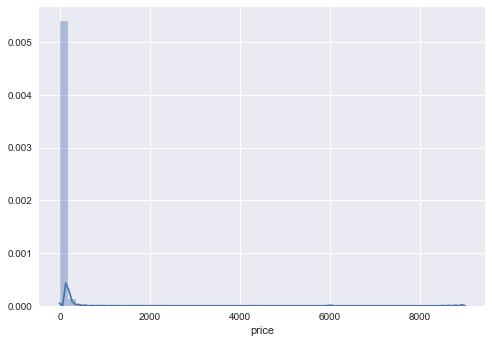

In [63]:
sns_plot = sns.distplot(df_raw['price'])
fig = sns_plot.get_figure()

Как мы видим, в большинстве своем цена за аренду лежит на промежутке от 0 до 100 долларов.

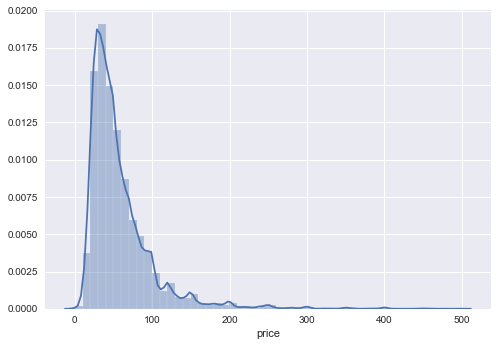

In [64]:
sns_plot = sns.distplot(df_raw['price'][df_raw['price']<500])
fig = sns_plot.get_figure()

75% цен лежат на промежутке от 0 до 70 долларов. Так же есть и "выбросы", когда цены за аренду достигают 9000 долларов. Для модели такие показатели будут существенными "загрязнителями", ибо недвижимость в таких случаях больно элитная, а подобных наблюдений слишком мало. Принял решение ограничиться 400 долларами за аренду, а все остальное- удалить из выборки. Так же удалю и наблюдения, в которых цена 0 долларов.

In [65]:
df_raw.drop(df_raw[ (df_raw.price > 400) | (df_raw.price == 0) ].index, axis=0, inplace=True)

Проверяю, какие еще колонки с пропущенными данными я имею.

In [66]:
df_raw.isna().sum()

space                            8503
description                       202
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

Чтобы не работать с тексотом- оставляю от описания лишь количество слов в описании. (нагло подсмотрел и украл код из notebook'a выше)

In [67]:
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3)*100, '%')

NaNs in size_column absolute:      11744
NaNs in size_column in percentage: 52.300000000000004 %


Удаляю колонки 'square_feet', 'space','description' так как считаю, что проще будет без них, нежели пытаться заполнить их какими- либо значениями. Так же удаляю наблюдения, в которых не заполнены колонки 'bathrooms', 'bedrooms'

In [68]:
df_raw.drop(columns=['square_feet', 'space','description'], inplace=True)
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

У поля о наличии или отцутствии аватарки пользователя у арендодателя значения true/false и 25 пропусков. будем считать, что там, где пропуски- значение false.

In [69]:
df_raw.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [70]:
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [71]:
df_raw.isna().sum()

host_has_profile_pic                0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
size                            11721
dtype: int64

In [72]:
print("The dataset now has {} rows and {} columns".format(*df_raw.shape))

The dataset now has 22391 rows and 21 columns


In [73]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22391 entries, 2015 to 29867352
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   host_has_profile_pic          22391 non-null  object 
 1   neighbourhood_group_cleansed  22391 non-null  object 
 2   latitude                      22391 non-null  float64
 3   longitude                     22391 non-null  float64
 4   property_type                 22391 non-null  object 
 5   room_type                     22391 non-null  object 
 6   accommodates                  22391 non-null  int64  
 7   bathrooms                     22391 non-null  float64
 8   bedrooms                      22391 non-null  float64
 9   bed_type                      22391 non-null  object 
 10  amenities                     22391 non-null  object 
 11  price                         22391 non-null  float64
 12  cleaning_fee                  22391 non-null  float64


In [74]:
df_raw.head()

,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,size
id,,,,,,,,,,,,,,,,,,,,,
2015,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,...,60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,75.0
2695,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,...,17.0,0.0,0.0,0.0,1,2,f,f,flexible,25.0
3176,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,...,90.0,50.0,200.0,20.0,2,62,t,f,strict_14_with_grace_period,68.0
3309,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,...,26.0,30.0,250.0,18.0,1,5,f,f,strict_14_with_grace_period,26.0
7071,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,...,42.0,0.0,0.0,24.0,1,2,f,f,moderate,20.0


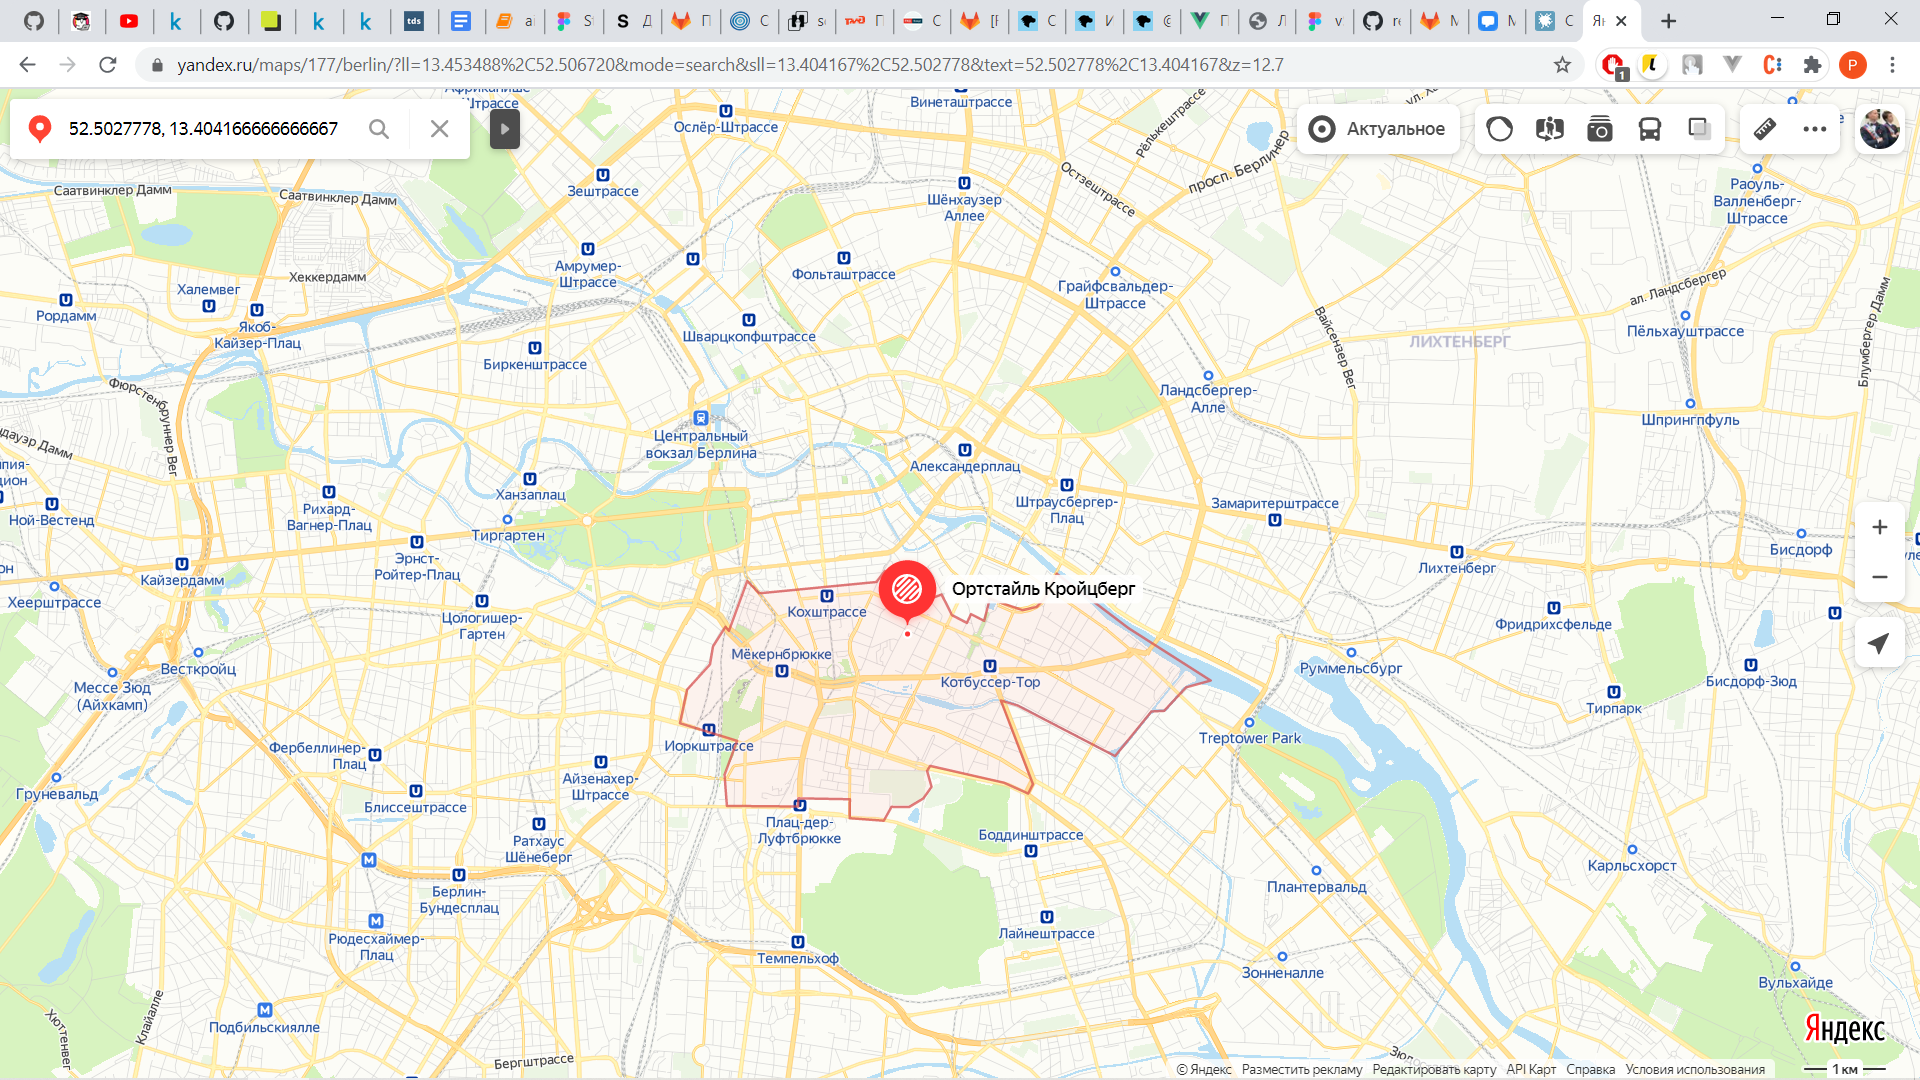

52.5027778, 13.404166666666667- беру данные координаты в качестве центра Берлина.

In [75]:
def distance_to_centre(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [76]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_centre(x.latitude, x.longitude), axis=1)

Рассчитали расстояние до центра берлина для каждого из наших наблюдений. Это важно для дальнейшего предсказания цены на аренду.

In [77]:
df_raw.head()

,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,...,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,size,distance
id,,,,,,,,,,,,,,,,,,,,,
2015,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,...,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,75.0,3.533182
2695,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,...,0.0,0.0,0.0,1,2,f,f,flexible,25.0,5.085573
3176,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,...,50.0,200.0,20.0,2,62,t,f,strict_14_with_grace_period,68.0,3.695677
3309,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,...,30.0,250.0,18.0,1,5,f,f,strict_14_with_grace_period,26.0,3.755285
7071,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,...,0.0,0.0,24.0,1,2,f,f,moderate,20.0,4.550423


In [78]:
df_raw.isna().sum()

host_has_profile_pic                0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
size                            11721
distance                            0
dtype: int64

Теперь нужно заняться заполнением 50! процентов пропущенных значений в поле size. Сделаю это при помощи простой модельки.

Создаем мини- датасет для предикта количества слов в описании к позиции и разбиваем его на тест и трейн подмножества (получилось пополам)

In [79]:
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [80]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

y_train = train_data['size']

In [81]:
X_train

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423
...,...,...,...,...,...,...,...,...,...
29830381,2,0.5,1.0,30.0,25.0,200.0,10.0,1,1.140742
29842909,2,1.0,0.0,100.0,0.0,0.0,0.0,1,1.988263
29846605,4,3.0,2.0,105.0,60.0,0.0,15.0,1,3.025901


Использую линейную регрессию и замеряю время, которое требует модель для обучения.

Пытаюсь подобрать качественную модель для заполнения пропусков.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop('size', axis=1), train_data['size'], test_size=0.33, random_state=42)
reg = linear_model.LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))
print(mean_squared_error(y_test, predicted))

0.03903514624816595
0.018289673473645185
13548.03886386769


In [84]:
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)
start_time = time.time()
reg = linear_model.LinearRegression(n_jobs=-1)
reg.fit(X_train, train_data['size'])
predicted = reg.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.02094864845275879 seconds ---


In [85]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

y_train = train_data['size']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop('size', axis=1), train_data['size'], test_size=0.33, random_state=42)

In [87]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))
predicted = regr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, predicted)))

0.8597006126736166
-0.019438999577517935
118.6115985976539


In [88]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}
CV_rfc = GridSearchCV(estimator=regr, param_grid=param_grid, cv= 3, n_jobs=-1, verbose=True)
CV_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [89]:
print(CV_rfc.score(X_train, y_train))
print(CV_rfc.score(X_test, y_test))
predicted = CV_rfc.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, predicted)))

0.2870169608630263
0.029662347511999365
115.71988120944845


Деревья показали себя немного лучше регрессии (МСЕ меньше на 4), так что использую именно их.

In [90]:
CV_rfc.fit(train_data.drop('size', axis=1), train_data['size'])
predicted = CV_rfc.predict(test_data.drop('size', axis=1))
predicted = pd.DataFrame(predicted)
predicted.columns = ['size']
predicted.head()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.9s finished


,size
0,64.732228
1,105.818583
2,75.530794
3,100.089865
4,66.100727


In [91]:
prelim_index = pd.DataFrame(test_data.drop('size', axis=1).index)
prelim_index.columns = ['prelim']

predicted = pd.concat([predicted, prelim_index], axis=1)
predicted.set_index(['prelim'], inplace=True)
predicted.head()

,size
prelim,
14325,64.732228
20858,105.818583
21869,75.530794
22415,100.089865
28156,66.100727


In [92]:
new_test_data = pd.concat([test_data.drop('size', axis=1), predicted], axis=1)

In [93]:
print(new_test_data.shape)
new_test_data.head()

(11721, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,64.732228
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,105.818583
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.530794
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,100.089865
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,66.100727


In [94]:
new_test_data['size'].isna().sum()

0

Замечательно, все пропуски заполнены оптимально.

Сливаю воедино наш тренировочный и тестовый датасеты.

In [95]:
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(22391, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,64.732228
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,105.818583
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.530794
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,100.089865
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,66.100727


Слил воедино весь датасет, теперь уже с заполненными пропусками.

In [96]:
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head()

(22391, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0,...,52.534996,13.417579,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",62,t,f,strict_14_with_grace_period
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0,...,52.498855,13.349065,Apartment,Private room,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",5,f,f,strict_14_with_grace_period
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0,...,52.543157,13.415091,Apartment,Private room,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",2,f,f,moderate


In [97]:
df.isna().sum()

accommodates                    0
bathrooms                       0
bedrooms                        0
price                           0
cleaning_fee                    0
security_deposit                0
extra_people                    0
guests_included                 0
distance                        0
size                            0
host_has_profile_pic            0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
bed_type                        0
amenities                       0
minimum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

Теперь пропусков в данных нет. Замечательно!

In [98]:
df.describe()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,latitude,longitude,minimum_nights
count,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000
mean,2.626055,1.090416,1.156179,57.587245,18.119646,117.151132,8.253673,1.327900,4.547464,60.338400,52.509824,13.406225,7.168907
std,1.471965,0.322431,0.629371,42.193976,24.689926,299.339020,11.099403,0.816494,2.661159,80.825486,0.030844,0.057908,40.794753
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.198956,0.000000,52.346203,13.103557,1.000000
25%,2.000000,1.000000,1.000000,30.000000,0.000000,0.000000,0.000000,1.000000,2.979687,25.000000,52.489015,13.375651,2.000000
50%,2.000000,1.000000,1.000000,45.000000,10.000000,0.000000,5.000000,1.000000,4.088758,49.578883,52.509081,13.416881,2.000000
75%,3.000000,1.000000,1.000000,70.000000,30.000000,150.000000,15.000000,1.000000,5.551307,65.624617,52.532697,13.439319,4.000000
max,16.000000,8.500000,9.000000,400.000000,450.000000,4280.000000,250.000000,16.000000,25.012109,980.000000,52.651670,13.757642,5000.000000


In [99]:
df['size'].describe()

count    22391.000000
mean        60.338400
std         80.825486
min          0.000000
25%         25.000000
50%         49.578883
75%         65.624617
max        980.000000
Name: size, dtype: float64

Есть большие выбросы в сторону большого размера. Возможно, стоит их почистить.

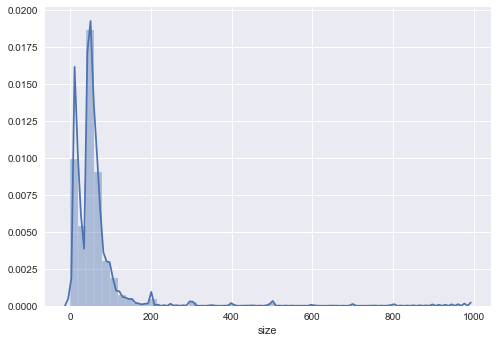

In [100]:
sns_plot = sns.distplot(df['size'])
fig = sns_plot.get_figure()

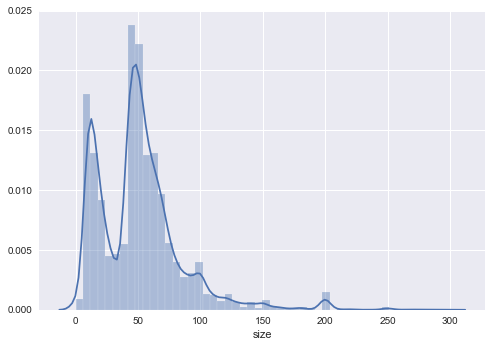

In [101]:
sns_plot = sns.distplot(df['size'][df['size']<300])
fig = sns_plot.get_figure()

Вот так картина выглядит намного лучше. Все, что справо- очевидно, обрезаю. Осталось посмотреть, сколько у нас size == 0

In [102]:
df['size'][df['size']==0].count()

120

120 наблюдений- многовато, их тоже стоит удалить из выборки.

In [103]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [104]:
df.shape

(21957, 22)

Надо что то делать с  Amenities (Удобства). Снова подглядываю в notebook старшего товарища и нахожу интересное решение.

In [105]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 20951),
 ('Kitchen', 20808),
 ('Heating', 20656),
 ('Essentials', 19810),
 ('Washer', 18070),
 ('Hair dryer', 14473),
 ('Laptop friendly workspace', 14095),
 ('Hangers', 13513),
 ('Iron', 10876),
 ('Shampoo', 10339),
 ('TV', 9778),
 ('Hot water', 9421),
 ('Family/kid friendly', 7925),
 ('Internet', 7698),
 ('Host greets you', 6468),
 ('Smoke detector', 6245),
 ('Buzzer/wireless intercom', 5963),
 ('Lock on bedroom door', 5138),
 ('Free street parking', 5037),
 ('Refrigerator', 5033),
 ('Dishes and silverware', 4909),
 ('Elevator', 4703),
 ('Cooking basics', 4673),
 ('Bed linens', 4656),
 ('Stove', 4655),
 ('Smoking allowed', 4509),
 ('Oven', 4161),
 ('translation missing: en.hosting_amenity_50', 4094),
 ('First aid kit', 3866),
 ('Cable TV', 3577)]

In [106]:
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

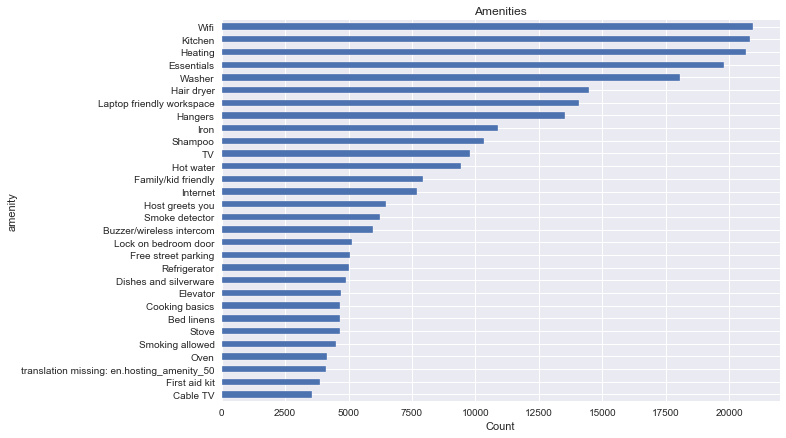

In [107]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False,
                                                      title='Amenities')
plt.xlabel('Count');

In [108]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')
df.drop(['amenities'], axis=1, inplace=True)

In [109]:
df.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,bed_type,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,Real Bed,4,f,f,strict_14_with_grace_period,True,True,True,False,False
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,Real Bed,2,f,f,flexible,True,False,False,False,False
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0,...,Real Bed,62,t,f,strict_14_with_grace_period,True,False,True,False,False
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0,...,Pull-out Sofa,5,f,f,strict_14_with_grace_period,True,False,False,True,False
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0,...,Real Bed,2,f,f,moderate,True,False,True,False,False


Строим распределение цен относительно долготы и широты.

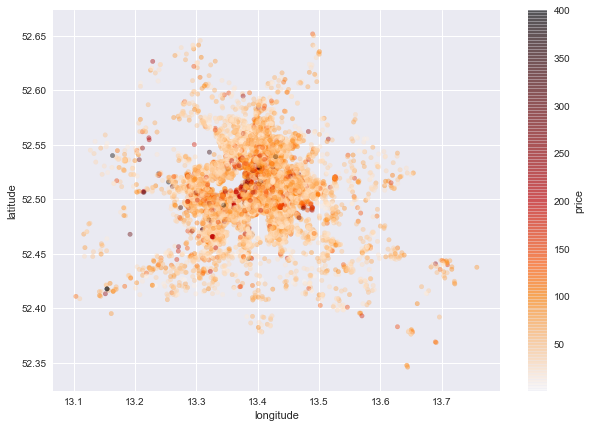

In [110]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

Смотрю, как взаимосвязаны средняя цена и расстояние до центра Берлина

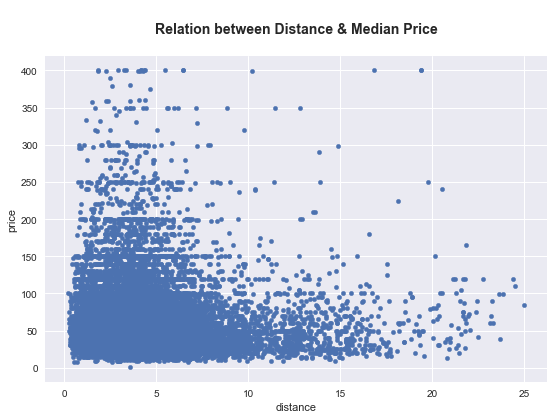

In [111]:
df.plot.scatter(x="distance", y="price", figsize=(9,6),)
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

Смотрю соотношение цены и площади арендуемого жилья.

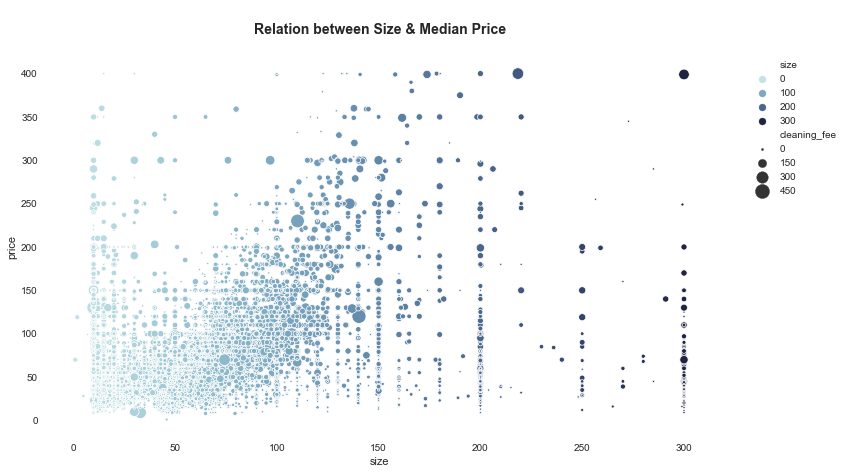

In [112]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Как можно увидеть на графике ниже- цена за аренду растет вместе со строгостью отмены и возврата за нее денег.

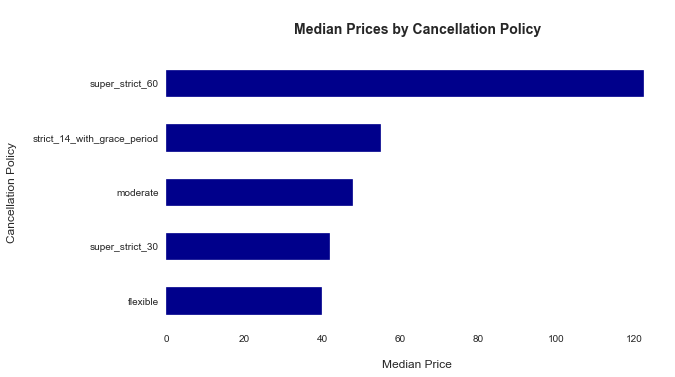

In [113]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

Выбрасываю уже не нужные долготу и широту. Вместо них у нас расстояние до центра Берлина. 'neighbourhood_group_cleansed', 'property_type' тоже посчитал ненужными.

In [114]:
df.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,bed_type,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,Real Bed,4,f,f,strict_14_with_grace_period,True,True,True,False,False
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,Real Bed,2,f,f,flexible,True,False,False,False,False
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0,...,Real Bed,62,t,f,strict_14_with_grace_period,True,False,True,False,False
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0,...,Pull-out Sofa,5,f,f,strict_14_with_grace_period,True,False,False,True,False
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0,...,Real Bed,2,f,f,moderate,True,False,True,False,False


In [115]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)
df.corr()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed
accommodates,1.000000,0.241345,0.622651,0.574726,0.354844,0.117551,0.247378,0.506946,0.056068,0.315660,0.000463,0.062355,0.240827,0.346477,0.020450,-0.103409
bathrooms,0.241345,1.000000,0.303614,0.251777,0.138925,0.052011,0.061116,0.169734,0.022510,0.190330,-0.004453,0.026135,0.080178,0.075623,0.001011,-0.014280
bedrooms,0.622651,0.303614,1.000000,0.470965,0.275852,0.113687,0.141875,0.373799,0.048636,0.262665,0.005612,0.050788,0.150925,0.259325,0.019769,-0.089864
price,0.574726,0.251777,0.470965,1.000000,0.404485,0.180816,0.193780,0.412369,-0.064919,0.386949,0.022816,0.083412,0.269418,0.231927,0.045171,-0.151312
cleaning_fee,0.354844,0.138925,0.275852,0.404485,1.000000,0.422601,0.257456,0.293510,0.000673,0.277990,0.107040,0.117812,0.236772,0.193123,0.115822,-0.155505
security_deposit,0.117551,0.052011,0.113687,0.180816,0.422601,1.000000,0.124409,0.098439,-0.010849,0.151820,0.132141,0.043532,0.114267,0.085893,0.060021,-0.091713
extra_people,0.247378,0.061116,0.141875,0.193780,0.257456,0.124409,1.000000,0.329920,0.002611,0.151286,-0.012555,0.079638,0.092304,0.145495,0.133994,-0.044737
guests_included,0.506946,0.169734,0.373799,0.412369,0.293510,0.098439,0.329920,1.000000,0.014072,0.216072,0.009765,0.050081,0.157694,0.223746,0.043061,-0.081008
distance,0.056068,0.022510,0.048636,-0.064919,0.000673,-0.010849,0.002611,0.014072,1.000000,-0.082211,0.004871,0.016894,0.127571,0.038624,0.044442,-0.050633
size,0.315660,0.190330,0.262665,0.386949,0.277990,0.151820,0.151286,0.216072,-0.082211,1.000000,0.016593,0.056510,0.160303,0.140350,0.025289,-0.086296


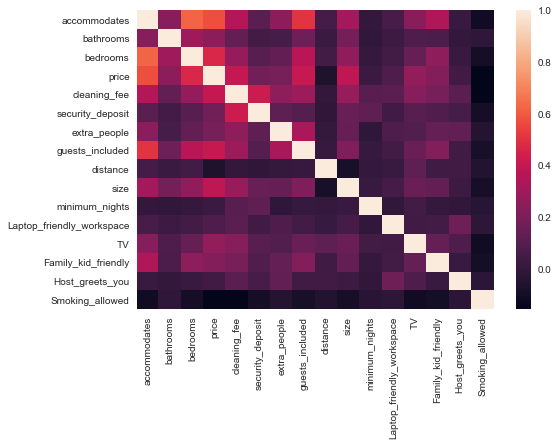

In [116]:
sns.heatmap(df.corr())

Делаю 'host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy' категориальными

In [117]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

Выношу в отдельную переменную нашу целевую переменную

In [118]:
target = df[["price"]]
features = df.drop(["price"], axis=1)

Далее- все категориальные переменные делаю дамми-переменными.

In [119]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

И наконец сливаю все воедино. На этом предобработка даных завершена.

In [201]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)
features_recoded['bathrooms'] = features_recoded['bathrooms'].astype(int)
features_recoded['bedrooms'] = features_recoded['bedrooms'].astype(int)
features_recoded['extra_people'] = features_recoded['extra_people'].astype(int)

In [202]:
target.to_csv('target.csv', sep=';', encoding='utf-8')
features_recoded.to_csv('features.csv', sep=';', encoding='utf-8')

In [203]:
print(features_recoded.shape)
features_recoded.head()

(21957, 33)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1,1,30.0,200.0,28,1,3.533182,75.0,4,...,0,1,1,0,1,0,0,1,0,0
2695,2,1,1,0.0,0.0,0,1,5.085573,25.0,2,...,0,1,1,0,1,1,0,0,0,0
3176,4,1,1,50.0,200.0,20,2,3.695677,68.0,62,...,0,1,0,1,1,0,0,1,0,0
3309,2,1,1,30.0,250.0,18,1,3.755285,26.0,5,...,1,0,1,0,1,0,0,1,0,0
7071,2,1,1,0.0,0.0,24,1,4.550423,20.0,2,...,0,1,1,0,1,0,1,0,0,0


Далее- модельки!

Разбиваю датасет

In [173]:
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

Стандартизирую трейн и тест
Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

In [174]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

На гриде нахожу оптимальные параметры для буста

In [165]:
booster = xgb.XGBRegressor()

In [ ]:
param_grid = {'n_estimators': [150, 200, 250],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.1, 0.2, 0.25]}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, y_train)

print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}

Обучаю модель на оптимальных параметрах

In [175]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.25, learning_rate=0.1, 
                           max_depth=7, n_estimators=250)

booster.fit(X_train, y_train)

y_pred_test = booster.predict(X_test)

И последнее- смотрю метрики качества, которыми остаюсь вполне доволен.

In [176]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {RMSE}")

RMSE: 22.930623849359254


Результат из рук вон замечательный!)
RMSE: 22.175716159283695
r2: 0.7069740050225961

In [177]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {r2}")

r2: 0.6717214154127864


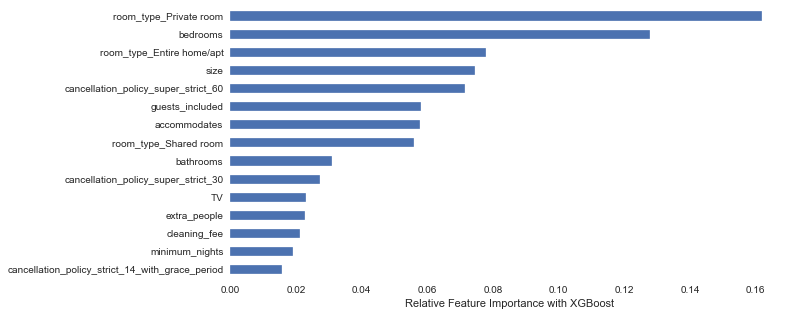

In [178]:
feat_importances_4 = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances_4.nlargest(15).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

In [201]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
for i in range(1,70):
    booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, 
                           max_depth=7, n_estimators=250, random_state=i)
    booster.fit(X_train, y_train)
    y_pred_test = booster.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE and  best_r2 < r2:
        best_id = i
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = i
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = i

In [206]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, 
                           max_depth=7, n_estimators=250, random_state=20)
booster.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=20, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [203]:
print("Best RMSE: {} best RMSE id: {} best r2: {} best r2 id: {}, best_id: {}"
      .format(best_RMSE, id_RMSE, best_r2, id_r2, best_id))

Best RMSE: 23.631991984156514 best RMSE id: 20 best r2: 0.6750649511717904 best r2 id: 20, best_id: 20


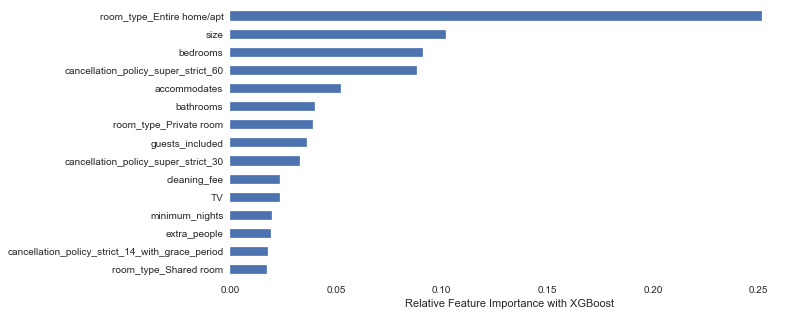

In [207]:
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

In [187]:
features_recoded.head()

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,...,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,...,0,1,1,0,1,1,0,0,0,0
3176,4,1.0,1.0,50.0,200.0,20.0,2,3.695677,68.0,62,...,0,1,0,1,1,0,0,1,0,0
3309,2,1.0,1.0,30.0,250.0,18.0,1,3.755285,26.0,5,...,1,0,1,0,1,0,0,1,0,0
7071,2,1.0,1.0,0.0,0.0,24.0,1,4.550423,20.0,2,...,0,1,1,0,1,0,1,0,0,0


Как оказалось, мучения с расстоянием от центра Берлина оказались напрасны. А вот дамми-переменные внесли в модель наибольшие корректировки.

К следующей лабе сделаю то же самое, но уже со случайным лесом и гридом из sklearn.

Что касается анализа выше- notebook, с которого я брал пример выбил RMSE: 23.6884 r2: 0.6718. так что у меня не все так плохо.

Пытаюсь улучшить хгбуст

In [208]:
param_grid = {'n_estimators': [240, 250, 270, 300],
              'learning_rate': [0.09, 0.1, 0.11, 0.13], 
              'max_depth': [6, 7, 8],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.07, 0.1, 0.13]}

booster = xgb.XGBRegressor()
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, y_train)

print(booster_grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 17.6min finished


{'colsample_bytree': 0.6, 'gamma': 0.13, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}


Обучаю бустер на лучших параметрах с грида.

In [209]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.13, learning_rate=0.1, 
                           max_depth=6, n_estimators=300)

booster.fit(X_train, y_train)

y_pred_test = booster.predict(X_test)

Просматриваю результаты по разным метрикам качества модели

In [210]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {RMSE}")

RMSE: 24.056315158440263


In [211]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {r2}")

r2: 0.6632914791910283


In [212]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
for i in range(1,70):
    booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.13, learning_rate=0.1, 
                           max_depth=6, n_estimators=300, random_state=i)
    booster.fit(X_train, y_train)
    y_pred_test = booster.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE and  best_r2 < r2:
        best_id = i
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = i
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = i

In [213]:
print("Best RMSE: {} best RMSE id: {} best r2: {} best r2 id: {}, best_id: {}"
      .format(best_RMSE, id_RMSE, best_r2, id_r2, best_id))

Best RMSE: 23.912656275315125 best RMSE id: 13 best r2: 0.6673009660028657 best r2 id: 13, best_id: 13


In [81]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.13, learning_rate=0.1, 
                           max_depth=6, n_estimators=300)
booster.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.13, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

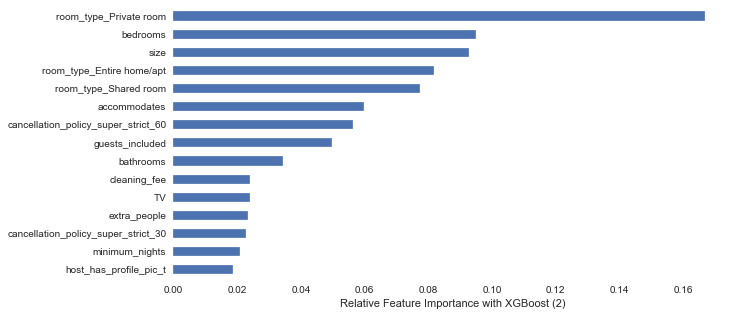

In [82]:
feat_importances_2 = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances_2.nlargest(15).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost (2)');

Попробую исключить маловажные факторы из модели и обучить хгбуст заново.

In [83]:
feat_importances_2.nlargest(15).sort_values().keys()

Index(['host_has_profile_pic_t', 'minimum_nights',
       'cancellation_policy_super_strict_30', 'extra_people', 'TV',
       'cleaning_fee', 'bathrooms', 'guests_included',
       'cancellation_policy_super_strict_60', 'accommodates',
       'room_type_Shared room', 'room_type_Entire home/apt', 'size',
       'bedrooms', 'room_type_Private room'],
      dtype='object')

In [84]:
drop_features_xgboost = features_recoded[feat_importances_2.nlargest(15).sort_values().keys()]
drop_features_xgboost.head()

,host_has_profile_pic_t,minimum_nights,cancellation_policy_super_strict_30,extra_people,TV,cleaning_fee,bathrooms,guests_included,cancellation_policy_super_strict_60,accommodates,room_type_Shared room,room_type_Entire home/apt,size,bedrooms,room_type_Private room
2015,1,4,0,28.0,True,30.0,1.0,1,0,3,0,1,75.0,1.0,0
2695,1,2,0,0.0,False,0.0,1.0,1,0,2,0,0,25.0,1.0,1
3176,1,62,0,20.0,False,50.0,1.0,2,0,4,0,1,68.0,1.0,0
3309,1,5,0,18.0,False,30.0,1.0,1,0,2,0,0,26.0,1.0,1
7071,1,2,0,24.0,False,0.0,1.0,1,0,2,0,0,20.0,1.0,1


In [85]:
X_train, X_test, y_train, y_test = train_test_split(drop_features_xgboost, target, test_size=0.2)

In [86]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [87]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.13, learning_rate=0.1, 
                           max_depth=6, n_estimators=300)

booster.fit(X_train, y_train)

y_pred_test = booster.predict(X_test)

In [88]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {RMSE}")

RMSE: 24.882255298318956


In [89]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {r2}")

r2: 0.6704309699287558


Бинго! это- лучший результат из всех, что выбил.

Пробую теперь найти что- то лучше при помощи рандомного стэйта

In [230]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
for i in range(1,70):
    booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.13, learning_rate=0.1, 
                           max_depth=6, n_estimators=300, random_state=i)
    booster.fit(X_train, y_train)
    y_pred_test = booster.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE and  best_r2 < r2:
        best_id = i
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = i
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = i

In [231]:
print("Best RMSE: {} best RMSE id: {} best r2: {} best r2 id: {}, best_id: {}"
      .format(best_RMSE, id_RMSE, best_r2, id_r2, best_id))

Best RMSE: 22.94500714911841 best RMSE id: 19 best r2: 0.678659481198302 best r2 id: 19, best_id: 19


Неплохой результат, но далеко не лучший.

Пробую Рандом форест на той же задаче

In [232]:
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

In [233]:
rfreereg = RandomForestRegressor(n_jobs=-1)
param_grid = {
    'n_estimators': [180, 200, 220],
    'max_depth': [7,8,9,10],
    'min_samples_split': [3,4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfreereg_grid_search = GridSearchCV(rfreereg, param_grid, cv=3, n_jobs=-1, verbose=True)

rfreereg_grid_search.fit(X_train, y_train)

print(rfreereg_grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  3.0min finished


{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 180}


In [240]:
rfreereg = RandomForestRegressor(max_depth=10, n_estimators=180, min_samples_split=4, max_features='auto')

rfreereg.fit(X_train, y_train)

y_pred_test = rfreereg.predict(X_test)

In [235]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {RMSE}")

RMSE: 25.486514128835502


In [236]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {r2}")

r2: 0.6498585518383091


In [238]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
for i in range(1,70):
    rfreereg = RandomForestRegressor(max_depth=10, n_estimators=180, min_samples_split=4, max_features='auto', random_state=i)
    
    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE and  best_r2 < r2:
        best_id = i
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = i
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = i

In [239]:
print("Best RMSE: {} best RMSE id: {} best r2: {} best r2 id: {}, best_id: {}"
      .format(best_RMSE, id_RMSE, best_r2, id_r2, best_id))

Best RMSE: 25.37900281024555 best RMSE id: 21 best r2: 0.652806367318074 best r2 id: 21, best_id: 21


Как мы видим, по обеим метрикам качества проигрывает случайный лес и довольно существенно. Так что лучшим буду считать хгбуст.

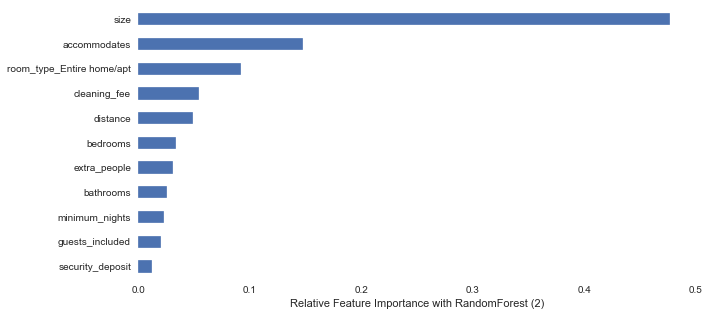

In [241]:
feat_importances_3 = pd.Series(rfreereg.feature_importances_, index=features_recoded.columns)
feat_importances_3.nlargest(11).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with RandomForest (2)');

Выбрасываю фичи, не вошедшие в топ -11 самых "полезных"

In [242]:
drop_features_randomforest = features_recoded[feat_importances_3.nlargest(11).sort_values().keys()]
drop_features_randomforest.head()

,security_deposit,guests_included,minimum_nights,bathrooms,extra_people,bedrooms,distance,cleaning_fee,room_type_Entire home/apt,accommodates,size
2015,200.0,1,4,1.0,28.0,1.0,3.533182,30.0,1,3,75.0
2695,0.0,1,2,1.0,0.0,1.0,5.085573,0.0,0,2,25.0
3176,200.0,2,62,1.0,20.0,1.0,3.695677,50.0,1,4,68.0
3309,250.0,1,5,1.0,18.0,1.0,3.755285,30.0,0,2,26.0
7071,0.0,1,2,1.0,24.0,1.0,4.550423,0.0,0,2,20.0


In [243]:
X_train, X_test, y_train, y_test = train_test_split(drop_features_randomforest, target, test_size=0.2)

rfreereg = RandomForestRegressor(max_depth=10, n_estimators=220, min_samples_split=4, max_features='auto')

rfreereg.fit(X_train, y_train)

y_pred_test = rfreereg.predict(X_test)

In [244]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {RMSE}")

RMSE: 24.839635698102327


In [245]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {r2}")

r2: 0.619572326511943


Деревья с выброшенными лишними фичами намного лучше.

Пробую теперь PCA

In [247]:
pca = PCA(n_components=10)
new_features = StandardScaler().fit_transform(features_recoded)
new_features = pca.fit_transform(new_features)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.1280002  0.06680614 0.06279786 0.06018652 0.05158343 0.04768733
 0.044838   0.0358952  0.03537819 0.03239664]
[299.90016609 216.66041333 210.0602213  205.64635298 190.38226365
 183.05133246 177.49842356 158.81428158 157.6664087  150.87641756]


Разбиваю новый, преобразованный датасет на тест и трейн

In [248]:
X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size=0.2)

Перебираю различное количество компонент, останавливаюсь на 5

In [249]:
for i in range(1,15):
    pca = PCA(n_components=i)
    new_features = StandardScaler().fit_transform(features_recoded)
    new_features = pca.fit_transform(new_features)
    
    X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size=0.2)
    best_RMSE = 999999
    best_r2 = 0
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt')

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
    if best_r2 < r2:
        best_r2 = r2
    print("RMSE: {} r2: {} PCA_num: {}".format(best_RMSE, best_r2, i))

RMSE: 32.85098025298359 r2: 0.4154442425874362 PCA_num: 1
RMSE: 30.75955228751434 r2: 0.46643004805341837 PCA_num: 2
RMSE: 32.10691898168001 r2: 0.45248988303571025 PCA_num: 3
RMSE: 30.727072422496533 r2: 0.46601841324945426 PCA_num: 4
RMSE: 30.6915200772431 r2: 0.4745861575111677 PCA_num: 5
RMSE: 31.422371761801895 r2: 0.48111322222237785 PCA_num: 6
RMSE: 30.54373656625937 r2: 0.46090071794416 PCA_num: 7
RMSE: 30.091013461487982 r2: 0.48326290870022337 PCA_num: 8
RMSE: 30.89044936228342 r2: 0.4806992235893033 PCA_num: 9
RMSE: 30.594512101710208 r2: 0.4903939638842898 PCA_num: 10
RMSE: 29.12878292793381 r2: 0.4809654809825653 PCA_num: 11
RMSE: 30.149658390672684 r2: 0.4818517270302016 PCA_num: 12
RMSE: 30.443793479753268 r2: 0.49012276525888143 PCA_num: 13
RMSE: 29.935949602606712 r2: 0.4886692975044151 PCA_num: 14


In [250]:
print("RMSE: {} r2: {} PCA_num: {}"
      .format(best_RMSE, best_r2, i))

RMSE: 29.935949602606712 r2: 0.4886692975044151 PCA_num: 14


In [251]:
pca = PCA(n_components=5)
new_features = StandardScaler().fit_transform(features_recoded)
new_features = pca.fit_transform(new_features)

In [252]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.singular_values_)
print(pca.explained_variance_ratio_.sum())

[0.1280001  0.06679582 0.06277435 0.06013386 0.05130331]
[4.09618975 2.13756356 2.00887079 1.92437122 1.64178075]
[299.90004739 216.64367761 210.02089407 205.55636425 189.86463607]
0.3690074465090736


Тут видно, что не очень то они и хорошо объясняют искодный датасет

In [253]:
X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size=0.2)

In [254]:
rfreereg = RandomForestRegressor(n_jobs=-1)
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2,3,4,5,6,7,8],
    'min_samples_split': [3,5,7,9],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfreereg_grid_search = GridSearchCV(rfreereg, param_grid, cv=3, n_jobs=-1, verbose=True)

rfreereg_grid_search.fit(X_train, y_train)

print(rfreereg_grid_search.best_params_)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  9.1min finished


{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 200}


Перебрал на гриде, дальше буду использовать лучшую модель

In [259]:
rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt', n_jobs=-1)

rfreereg.fit(X_train, y_train)
y_pred_test = rfreereg.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2 = r2_score(y_test, y_pred_test)

print("RMSE: {} r2: {}".format(RMSE, r2))

RMSE: 32.68961549813699 r2: 0.4221256232838392


Модель лишь ухудшилась. Попробую выбить из нее результаты получше, задавая рандом

In [260]:
best_RMSE = 999999
best_r2 = 0
best_RMSE_i = 0
best_r2_i = 0

for i in range(1,50):
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt', n_jobs=-1,  random_state=i)

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        best_RMSE_i = i
    if best_r2 < r2:
        best_r2 = r2
        best_r2_i = i

In [261]:
print("RMSE: {} best_RMSE_i: {} r2: {} best_r2_i: {} PCA_num: 5".format(best_RMSE, best_RMSE_i, best_r2, best_r2_i))

RMSE: 32.57112229513869 best_RMSE_i: 36 r2: 0.42630738451244454 best_r2_i: 36 PCA_num: 5


А вот и максимум нашей модели. Не очень.

In [262]:
print(rfreereg.feature_importances_)

[0.67402797 0.0648422  0.12403759 0.06173575 0.07535649]


Минус PCA- влияние тех или иных фич на нашу модель теперь обезличено.

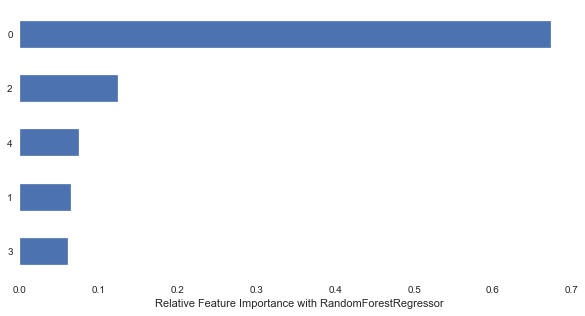

In [263]:
feat_importances = pd.Series(rfreereg.feature_importances_)
feat_importances.nlargest(5).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with RandomForestRegressor');

Ниже- попытка выбрасывать вручную наши фичи, вносящие малый вклад в модель.

In [268]:
drop_lst = [ 'distance', 'minimum_nights', 'cancellation_policy_super_strict_30', 'TV','extra_people', 'cleaning_fee']

In [270]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
k = 0
hand_features_recoded = features_recoded.copy()

for i in drop_lst:
    k+=1
    hand_features_recoded = hand_features_recoded.drop(i, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(hand_features_recoded, target, test_size=0.2)
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='auto')

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = k
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = k
    print("RMSE: {}, r2: {}, колонка на выброс: {}".format(RMSE, r2, i))
    
print("RMSE: {} best_RMSE: {} r2: {} best_r2: {}".format(best_RMSE, id_RMSE, best_r2, id_r2))

RMSE: 26.18601324552594, r2: 0.6096158216539271, колонка на выброс: distance
RMSE: 26.198202603570376, r2: 0.6080010454413987, колонка на выброс: minimum_nights
RMSE: 25.938538341210716, r2: 0.6158152270939856, колонка на выброс: cancellation_policy_super_strict_30
RMSE: 26.270248134741372, r2: 0.6061868585520727, колонка на выброс: TV
RMSE: 28.357847189190075, r2: 0.5807380104429872, колонка на выброс: extra_people
RMSE: 27.534117280437044, r2: 0.5900272662641649, колонка на выброс: cleaning_fee
RMSE: 25.938538341210716 best_RMSE: 3 r2: 0.6158152270939856 best_r2: 3


Попробую перебрать на гриде PCA вместе с бустом, может, что получится...

In [271]:
drop_lst = [ 'distance', 'TV', 'minimum_nights', 'extra_people']
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
k = 0
hand_features_recoded = features_recoded.copy()

for i in drop_lst:
    k+=1
    hand_features_recoded = hand_features_recoded.drop(i, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(hand_features_recoded, target, test_size=0.2)
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt')

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = k
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = k
    print("RMSE: {}, r2: {}, колонка на выброс: {}".format(RMSE, r2, i))
    
print("RMSE: {} best_RMSE: {} r2: {} best_r2: {}".format(best_RMSE, id_RMSE, best_r2, id_r2))

RMSE: 27.215279872269065, r2: 0.573418969811136, колонка на выброс: distance
RMSE: 27.80637684516511, r2: 0.5670582007395317, колонка на выброс: TV
RMSE: 25.940505766538127, r2: 0.5759886954503746, колонка на выброс: minimum_nights
RMSE: 27.27365351338641, r2: 0.573442286743179, колонка на выброс: extra_people
RMSE: 25.940505766538127 best_RMSE: 3 r2: 0.5759886954503746 best_r2: 3


По итогу лучшее, что получилось сделать с ручным выкидыванием маловажных фич- RMSE: 24.175734055093287, r2: 0.6112126409723664, колонка на выброс: distance

Нужно попробовать PCA На бусте вместе с удалением лишних фич вручную

In [273]:
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.1, 0.2]}

for i in range(4,8):
    best_RMSE = 999999
    best_r2 = 0
    
    pca = PCA(n_components=i)
    new_features_boost = StandardScaler().fit_transform(features_recoded)
    new_features_boost = pca.fit_transform(new_features_boost)
    
    X_train, X_test, y_train, y_test = train_test_split(new_features_boost, target, test_size=0.2)
    
    booster = xgb.XGBRegressor()

    booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)
    booster_grid_search.fit(X_train, y_train)
    
    y_pred_test = booster_grid_search.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    if best_RMSE > RMSE:
        best_RMSE = RMSE
    if best_r2 < r2:
        best_r2 = r2
        
    print(booster_grid_search.best_params_)   
    print("RMSE: {} r2: {} PCA_num: {}".format(best_RMSE, best_r2, i))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.6min finished


{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
RMSE: 30.934568995091155 r2: 0.4380630651355618 PCA_num: 4
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.1min finished


{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
RMSE: 30.206952042506593 r2: 0.46445535487204304 PCA_num: 5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.4min finished


{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
RMSE: 32.64544366587726 r2: 0.4534091312598122 PCA_num: 6
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.5min finished


{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 150}
RMSE: 28.535271063809642 r2: 0.49059186259527887 PCA_num: 7


На 5 компонентах получилась лучшая модель, но это все равно это и близко не тот результат, что был при ручном удалении фич.
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
RMSE: 29.34466269480948 r2: 0.48373509545185345 PCA_num: 5

Лучший результат из всех- "для кэгла" (по R^2): Best RMSE: 23.705060147997226 best RMSE id: 38 best r2: 0.6884031413053577 best r2 id: 38, best_id: 38 - ручное удаление фич для хгбуста и рандом=38

Best RMSE: 23.32430142523759 best RMSE id: 58 best r2: 0.6611713977548428 best r2 id: 58, best_id: 58 - Данный результат из грида по всем данным, хорош МСЕ.

Лучший же честный результат- RMSE: 24.03215443483169 r2: 0.6797446748062795, тоже на бусте с ручным удалением фич.

И последнее- чисто ради интереса. Попробую Ручное удаление фич в цикле с гридом, запускаю на ночь)

In [82]:
param_grid = {'n_estimators': [270, 300, 330],
              'learning_rate': [0.09, 0.1, 0.11], 
              'max_depth': [6, 7, 8],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.07, 0.1, 0]}

for i in range(10,20):
    
    drop_features_xgboost_cicle = features_recoded[feat_importances_4.nlargest(i).sort_values().keys()]
    X_train, X_test, y_train, y_test = train_test_split(drop_features_xgboost_cicle, target, test_size=0.2)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test  = sc.transform(X_test)
    
    booster = xgb.XGBRegressor()
    
    booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

    booster_grid_search.fit(X_train, y_train)
    
    y_pred_test = booster_grid_search.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    
    print(f"RMSE: {RMSE}")
    print(f"r2: {r2}")
    print(booster_grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.2min finished


RMSE: 26.65586569309877
r2: 0.5938338162811221
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 270}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.3min finished


RMSE: 26.979181683283063
r2: 0.6055098011415233
{'colsample_bytree': 0.6, 'gamma': 0.07, 'learning_rate': 0.09, 'max_depth': 6, 'n_estimators': 270}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.6min finished


RMSE: 25.950514231810835
r2: 0.6320874461045074
{'colsample_bytree': 0.7, 'gamma': 0.07, 'learning_rate': 0.09, 'max_depth': 7, 'n_estimators': 270}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.8min finished


RMSE: 24.488807161988102
r2: 0.6630897335863715
{'colsample_bytree': 0.7, 'gamma': 0.07, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 270}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.9min finished


RMSE: 25.241356806184488
r2: 0.6517668505425771
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.09, 'max_depth': 7, 'n_estimators': 270}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.1min finished


RMSE: 24.678534402040032
r2: 0.6549301432615113
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.09, 'max_depth': 6, 'n_estimators': 330}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.7min finished


RMSE: 24.992024928391515
r2: 0.6632532201447308
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 300}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.8min finished


RMSE: 23.44519863456401
r2: 0.6634745661544501
{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.09, 'max_depth': 7, 'n_estimators': 270}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.8min finished


RMSE: 23.37101337081785
r2: 0.6705107887920261
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 300}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  5.1min finished


RMSE: 25.339705510667528
r2: 0.6430482082576304
{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 270}


In [83]:
param_grid = {'n_estimators': [250, 270, 300, 350],
              'learning_rate': [0.07, 0.09, 0.1, 0.11], 
              'max_depth': [6, 7, 8],
              'colsample_bytree': [0.6, 0.7, 0.8, 1],
              'gamma': [0.06, 0.07, 0.08, 0.1, 0.12
                ]}

drop_features_xgboost_cicle = features_recoded[feat_importances_4.nlargest(18).sort_values().keys()]
X_train, X_test, y_train, y_test = train_test_split(drop_features_xgboost_cicle, target, test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

booster = xgb.XGBRegressor()

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, y_train)

y_pred_test = booster_grid_search.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"RMSE: {RMSE}")
print(f"r2: {r2}")
print(booster_grid_search.best_params_)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 47.2min finished


RMSE: 23.73613866842182
r2: 0.6696461210347202
{'colsample_bytree': 0.7, 'gamma': 0.12, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 300}


Побил Kaggle!
RMSE: 22.75660098431126
r2: 0.6711730240446001
{'colsample_bytree': 0.6, 'gamma': 0.06, 'learning_rate': 0.09, 'max_depth': 7, 'n_estimators': 270}

In [90]:
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.12, learning_rate=0.07, 
                           max_depth=8, n_estimators=300)
booster.fit(X_train, y_train)
y_pred_test = booster.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(r2, RMSE)

0.6696461210347202 23.73613866842182


In [91]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
for i in range(1,70):
    booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.06, learning_rate=0.09, 
                           max_depth=7, n_estimators=270, random_state=i)
    booster.fit(X_train, y_train)
    y_pred_test = booster.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE and  best_r2 < r2:
        best_id = i
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = i
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = i

In [92]:
print("Best RMSE: {} best RMSE id: {} best r2: {} best r2 id: {}, best_id: {}"
      .format(best_RMSE, id_RMSE, best_r2, id_r2, best_id))

Best RMSE: 23.37453710327312 best RMSE id: 30 best r2: 0.6796348195488215 best r2 id: 30, best_id: 30


(Сильно побил Kaggle, можно и еще сильнее, если играть с переразбиением данных, но это уже сумасшествие.)

Лучший результат по notebook-RMSE: 22.175716159283695 r2: 0.7069740050225961

Сумасшествие начинается ниже.

In [184]:
lst = []
for i in range(1,15):
    X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2, random_state = i)
    for j in range(1,10):
       

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test  = sc.transform(X_test)

        booster = xgb.XGBRegressor(random_state = j)
        param_grid = {'n_estimators': [200, 250, 300],
                      'learning_rate': [0.01, 0.03, 0.08], 
                      'max_depth': [6, 5, 8],
                      'colsample_bytree': [0.6, 0.8, 1],
                      'gamma': [0.1, 0.2, 0.15]}

        booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)
        booster_grid_search.fit(X_train, y_train)

        print(booster_grid_search.best_params_)

        y_pred_test = booster_grid_search.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2 = r2_score(y_test, y_pred_test)
        
        lst.append(["i: ", i, "j: ", j, "MSE: ", RMSE, "r2: ", r2])
        
        print("i: ", i, "j: ", j, "MSE: ", RMSE, "r2: ", r2)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 